In [36]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from torch import nn



from torch.utils.data.dataset import random_split

from torch import optim

import torch.nn.functional as F

import shutil


import numpy as np
import glob
import os
import warnings
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve, auc, accuracy_score
from sklearn.decomposition import PCA

import datetime

%matplotlib inline
warnings.filterwarnings("ignore")
plt.rcParams['xtick.labelsize'] = 10

### Additional functions

In [37]:
def calculate_auc_scores(y_test, y_prob, classes):
    auc_scores=[]
    for i in range(len(classes)):
        #prepare y_true as 1 if we have that class and 0 if not that class (other classes) - binarization
        y_true = [1 if y == i else 0 for y in y_test]
        auc_scores.append(roc_auc_score(y_true, y_prob[:,i]))

    return auc_scores

In [38]:
def plot_roc_curves_ovr(y_test, y_prob, classes, auc_scores):

    plt.figure(figsize=(9,5));

    colors=['b', 'g', 'r', 'c', 'm', 'y']

    for i in range(len(classes)):
        #prepare y_true as 1 if we have that class and 0 if not that class (other classes) - binarization
        y_true = [1 if y == i else 0 for y in y_test]
        fpr, tpr, _ = roc_curve(y_true, y_prob[:, i])

        sns.lineplot(x = fpr, y = tpr, label = classes[i]+ "  auc-score=%.4f" % auc_scores[i], color=colors[i]);
        plt.xlim(-0.05, 1.05);
        plt.ylim(-0.05, 1.05);
        plt.xlabel("False Positive Rate");
        plt.ylabel("True Positive Rate");

    sns.lineplot(x = [0, 1], y = [0, 1], color = 'blue', linestyle='--');

    plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.0));
    plt.title("Roc-curves for each class");
    plt.show();

In [39]:
def plot_precision_recall_curves(y_test, y_prob, classes):

    precision = dict()
    recall = dict()

    colors=['b', 'g', 'r', 'c', 'm', 'y']

    plt.figure(figsize=(9,5));
    for i in range(len(classes)):
        #prepare y_true as 1 if we have that class and 0 if not that class (other classes) - binarization of y_test
        y_true = np.array([1 if y == i else 0 for y in y_test])
        precision[i], recall[i], _ = precision_recall_curve(y_true,
                                                        y_prob[:, i])

        plt.plot(recall[i], precision[i], label=classes[i]+" auc-PR=%.4f" % auc(recall[i], precision[i]), color=colors[i]);

        baseline = len(y_true[y_true==1]) / len(y_true) # the fraction of that class in the whole dataset, the model which always predict that class will have such precision
        plt.plot([0, 1], [baseline, baseline], linestyle='--', color=colors[i])

    plt.xlabel("recall");
    plt.ylabel("precision");
    plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.0));
    plt.title("Precision vs. recall curve for each class");
    plt.show();

# Exploratory Data Analysis

In [40]:
train_path = "Classification_data/train/"
test_path = "Classification_data/test/"

#dirrectory for validation set. I will save there 20% images from the train set and use it for validation
val_path = 'Classification_data/validation/'

In [41]:
class2ind = {}
ind2class = {}

In [42]:
#prepare index to class dictionary
for i, folder in enumerate(os.listdir(train_path)):
   ind2class[i]=folder

In [43]:
#prepare class to index dictionary
class2ind={ind2class[i]: i  for i in range(len(ind2class))}

In [44]:
class2ind

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [57]:
def get_data(path):
    data = []
    labels = []
    file_names = []
    max_pixel_value = []
    min_pixel_value = []
    image_shapes = []
    for folder in glob.glob(path + '/*'):
        for filename in glob.glob(folder + "/*.jpg"):
        # print(filename)
            image = cv2.imread(filename)
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            #resize image to 20% of its size to make it smaller (30x30X3)
            # width = int(image.shape[1] * 0.5)
            # height = int(image.shape[0] * 0.5)
            # dim = (width, height)
            # # resize image
            # resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
            file_names.append(filename.strip())
            max_pixel_value.append(image[:,:].max())
            min_pixel_value.append(image[:,:].min())
            image_shapes.append(image.shape)

            data.append(image)
            label = filename.split('\\')[-2]
            labels.append(class2ind[label])

    statistics_df = pd.DataFrame({"filename": file_names,
                                  "max_intensity": max_pixel_value,
                                  "min_intensity": min_pixel_value,
                                  "shape": image_shapes})

    return data, labels, statistics_df


### Make validation dataset

To make validation dataset I will take 20% random images from each folder from the train data and save them into the validation directory.

In [46]:
#use this function only once to prepare validation set
def make_validation(path):
    save_path = val_path
    for folder in glob.glob(path + '/*'):
        files = []
        #make folder in the holdout directory
        folder_name=folder.split("\\")[-1]
        os.mkdir(os.path.join(save_path, folder_name))

        for filename in glob.glob(folder + "/*.jpg"):
            files.append(filename)
        #choose 20% of files in that folder
        indexes = np.random.choice(range(len(files)), size=int(0.2*len(files)), replace=False)
        for idx in indexes:
            #create image name
            image_name = files[idx].replace("\\", "/")
            #create save-name for file
            save_name =save_path+folder_name+"/"+image_name.split("/")[-1]
            #move file from train to validation folder
            shutil.move(image_name, save_name)


In [157]:
#don't use this function, if you already have validation folder
make_validation(train_path)

In [58]:
train_data, train_labels, train_statistics = get_data(train_path)
test_data, test_labels, test_statistics = get_data(test_path)
val_data, val_labels, val_statistics = get_data(val_path)

In [59]:
print("Length of Train data: ", len(train_data))
print("Length of Test data: ", len(test_data))
print("Length of Validation data: ", len(val_data))

Length of Train data:  11230
Length of Test data:  3000
Length of Validation data:  2804


In [55]:
def visualise_images(data, labels):
    #show 10 random images from data
    fig, axs = plt.subplots(2, 5, figsize=(20, 10))
    idx = np.random.randint(0, len(data), 10)
    for i, index in enumerate(idx):
        axs[i//5, i%5].imshow(data[index][:,:,[2,1,0]]) #[2,1,0] - to show images as RGB (not BGR)
        axs[i//5, i%5].axis("off")
        title = ind2class[labels[index]]
        axs[i//5, i%5].set_title(f"Class {title}")
        axs[i//5, i%5].axis("off")

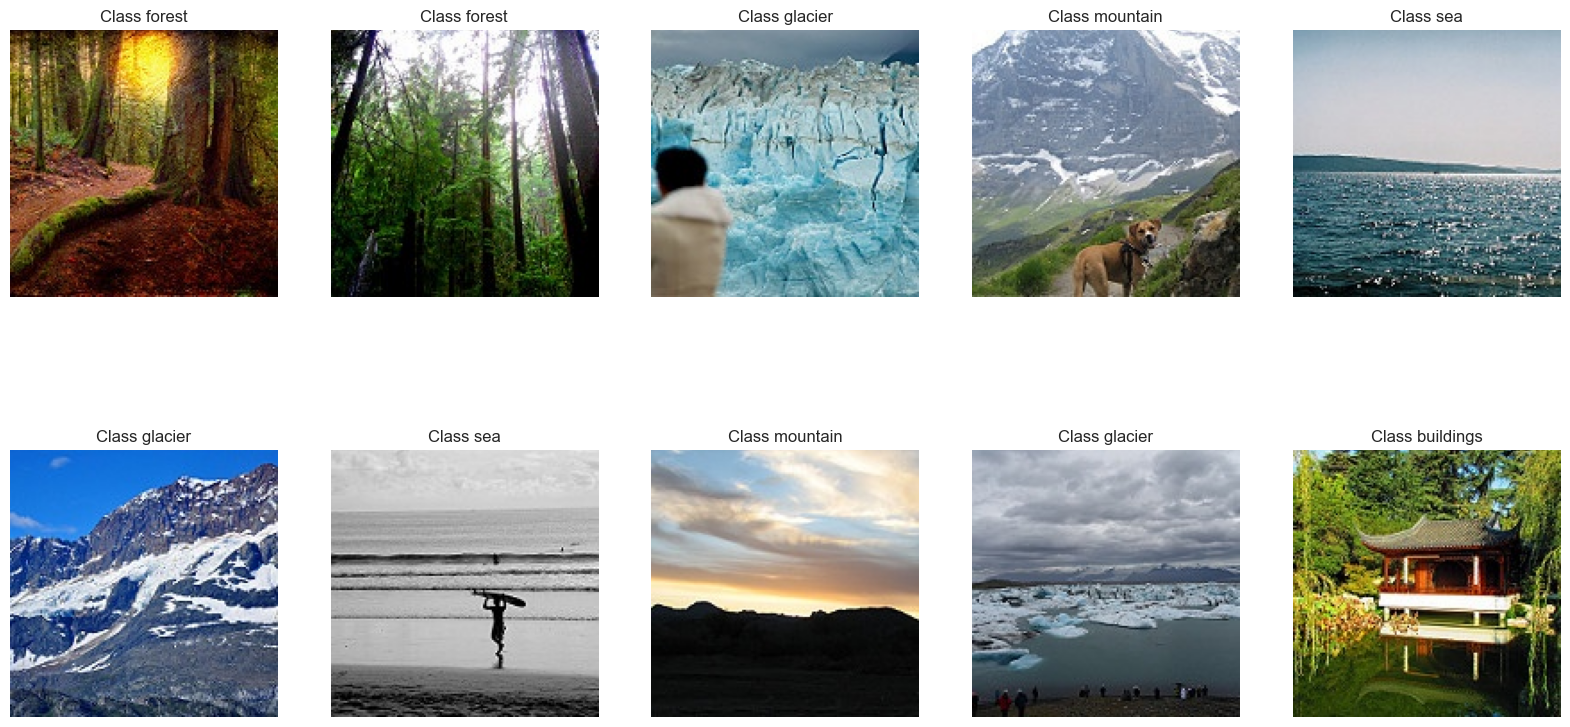

In [50]:
visualise_images(train_data, train_labels)

## Some data statistics

In [60]:
train_statistics

filename  max_intensity  \
0          Classification_data/train\buildings\0.jpg            255   
1      Classification_data/train\buildings\10006.jpg            255   
2       Classification_data/train\buildings\1001.jpg            255   
3      Classification_data/train\buildings\10018.jpg            255   
4      Classification_data/train\buildings\10056.jpg            255   
...                                              ...            ...   
11225      Classification_data/train\street\9961.jpg            255   
11226      Classification_data/train\street\9967.jpg            255   
11227      Classification_data/train\street\9978.jpg            255   
11228      Classification_data/train\street\9989.jpg            255   
11229       Classification_data/train\street\999.jpg            255   

       min_intensity          shape  
0                  0  (150, 150, 3)  
1                  0  (150, 150, 3)  
2                  0  (150, 150, 3)  
3                  0  (150, 150, 3)  
4                  0  (150, 150, 3)  
...              ...            ...  
11225              0  (150, 150, 3)  
11226              0  (150, 150, 3)  
11227              0  (150, 150, 3)  
11228              0  (150, 150, 3)  
11229              0  (150, 150, 3)  

[11230 rows x 4 columns]

Check dublicates

In [72]:
print("Number of duplicates in train:", train_statistics.duplicated().sum())
print("Number of duplicates in test: ", test_statistics.duplicated().sum())
print("Number of duplicates in validation:", val_statistics.duplicated().sum())

Number of duplicates in train: 0
Number of duplicates in test:  0
Number of duplicates in validation: 0


In [76]:
print(f"Min and max intensities in train: {train_statistics.min_intensity.min(), train_statistics.max_intensity.max()}")
print(f"Min and max intensities in test: {test_statistics.min_intensity.min(), test_statistics.max_intensity.max()}")
print(f"Min and max intensities in validation: {val_statistics.min_intensity.min(), val_statistics.max_intensity.max()}")

Min and max intensities in train: (0, 255)
Min and max intensities in test: (0, 255)
Min and max intensities in validation: (0, 255)


Check the shape of the images

In [77]:
train_statistics['shape'].value_counts()

(150, 150, 3)    11190
(113, 150, 3)        6
(111, 150, 3)        3
(108, 150, 3)        2
(135, 150, 3)        2
(143, 150, 3)        2
(146, 150, 3)        2
(134, 150, 3)        2
(123, 150, 3)        2
(131, 150, 3)        1
(147, 150, 3)        1
(81, 150, 3)         1
(145, 150, 3)        1
(141, 150, 3)        1
(100, 150, 3)        1
(103, 150, 3)        1
(144, 150, 3)        1
(119, 150, 3)        1
(97, 150, 3)         1
(76, 150, 3)         1
(102, 150, 3)        1
(124, 150, 3)        1
(149, 150, 3)        1
(105, 150, 3)        1
(136, 150, 3)        1
(115, 150, 3)        1
(133, 150, 3)        1
(140, 150, 3)        1
Name: shape, dtype: int64

In [78]:
test_statistics['shape'].value_counts()

(150, 150, 3)    2993
(141, 150, 3)       1
(110, 150, 3)       1
(76, 150, 3)        1
(149, 150, 3)       1
(72, 150, 3)        1
(131, 150, 3)       1
(81, 150, 3)        1
Name: shape, dtype: int64

In [79]:
val_statistics['shape'].value_counts()

(150, 150, 3)    2796
(142, 150, 3)       2
(135, 150, 3)       1
(110, 150, 3)       1
(120, 150, 3)       1
(113, 150, 3)       1
(136, 150, 3)       1
(144, 150, 3)       1
Name: shape, dtype: int64

We can see that we have images of different shapes, not only 150X150. But during training I will reshape images to that size (150X150).

# Classical approach

As features I will try color histograms and histograms of oriented gradients (HOGs).

In [16]:
def calc_color_hist(img):
    '''
    calculates color histogram of an image using HSV format
    '''
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([img], [0], None, [180], [0, 180])
    return list(hist.flatten())

In [17]:
def hog(img):
    '''
    calculate hostogram of oriented gradients (hog)
    '''
    hog = cv2.HOGDescriptor()
    #first resize image to get the same number of values
    img = cv2.resize(img, (64, 128), interpolation = cv2.INTER_AREA)
    h = hog.compute(img)
    return list(h)

In [285]:
#use one data for train and validation. futher will use in cross-validation
# train_data = train_data.extend(val_data)

### Color histograms as features

In [18]:
train_color_df = list(map(lambda x: calc_color_hist(x), train_data))
test_color_df = list(map(lambda x: calc_color_hist(x), test_data))

In [20]:
train_color_df = pd.DataFrame(train_color_df)
test_color_df = pd.DataFrame(test_color_df)

In [21]:
train_color_df

0      1      2      3      4      5      6      7      8      9    \
0       211.0   35.0   34.0   41.0   24.0   17.0   22.0   16.0   12.0   23.0   
1       707.0   91.0   83.0   85.0   98.0   92.0   95.0  122.0  115.0  125.0   
2       166.0   35.0   54.0   42.0   45.0   50.0   46.0   54.0   56.0   50.0   
3       102.0   10.0   25.0   12.0   20.0   17.0   20.0   18.0   10.0   22.0   
4       246.0   12.0   25.0   16.0   20.0   32.0   24.0   24.0   22.0   37.0   
...       ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
11225  1252.0  474.0  389.0  357.0  339.0  341.0  318.0  288.0  297.0  245.0   
11226   127.0    8.0   19.0   20.0   25.0   21.0   22.0   25.0   18.0   29.0   
11227   500.0   62.0   98.0   98.0   98.0  116.0   88.0   96.0  106.0  100.0   
11228   224.0   35.0   93.0   65.0   73.0   69.0   79.0  108.0  113.0  113.0   
11229   479.0   79.0  108.0   77.0   93.0   82.0   93.0  125.0   93.0  114.0   

       ...    170    171    172    173    174    175    176    177    178  \
0      ...    8.0   11.0   20.0   15.0   13.0   13.0   13.0   12.0   13.0   
1      ...   24.0   23.0   24.0   29.0   25.0   22.0   41.0   58.0   60.0   
2      ...  133.0  142.0  138.0  137.0  131.0  161.0  136.0  128.0  154.0   
3      ...   31.0   19.0   21.0   27.0   16.0   20.0   21.0   10.0   20.0   
4      ...   64.0   50.0   55.0   58.0   43.0   47.0   46.0   53.0   58.0   
...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
11225  ...   19.0   15.0   24.0   14.0   19.0   19.0   19.0   13.0   26.0   
11226  ...   87.0   90.0   94.0   84.0   74.0   91.0   81.0   86.0   82.0   
11227  ...   86.0   86.0   90.0   85.0  106.0   78.0  103.0   86.0   69.0   
11228  ...   24.0   41.0   31.0   31.0   41.0   48.0   49.0   70.0   54.0   
11229  ...   41.0   48.0   45.0   42.0   35.0   48.0   47.0   47.0   31.0   

         179  
0       18.0  
1       72.0  
2      127.0  
3       17.0  
4       57.0  
...      ...  
11225   20.0  
11226   80.0  
11227   66.0  
11228   77.0  
11229   50.0  

[11230 rows x 180 columns]

In [22]:
train_color_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11230 entries, 0 to 11229
Columns: 180 entries, 0 to 179
dtypes: float32(180)
memory usage: 7.7 MB


## Logistic regression

### Base model

In [23]:
#base model
lr = LogisticRegression(random_state=42)

In [24]:
lr.fit(train_color_df, train_labels)

LogisticRegression(random_state=42)

In [25]:
y_pred = lr.predict(test_color_df)
y_probs = lr.predict_proba(test_color_df)

In [26]:
print(f"Accuracy: {accuracy_score(test_labels, y_pred): .4f}")

Accuracy:  0.3697


Color histograms are very poor features for Linear Regression in this dataset. Let's try histograms of oriented gradients (HOGs).

### HOG features

In [18]:
train_hog_df = list(map(lambda x: hog(x), train_data))
test_hog_df = list(map(lambda x: hog(x), test_data))

In [19]:
train_hog_df = pd.DataFrame(train_hog_df)
test_hog_df = pd.DataFrame(test_hog_df)

In [20]:
train_hog_df.shape

(11230, 3780)

In [21]:
lr = LogisticRegression(random_state=42)
lr.fit(train_hog_df, train_labels)

LogisticRegression(random_state=42)

In [22]:
y_pred = lr.predict(test_hog_df)
y_probs = lr.predict_proba(test_hog_df)

In [23]:
print(f"Accuracy: {accuracy_score(test_labels, y_pred): .4f}")

Accuracy:  0.6717


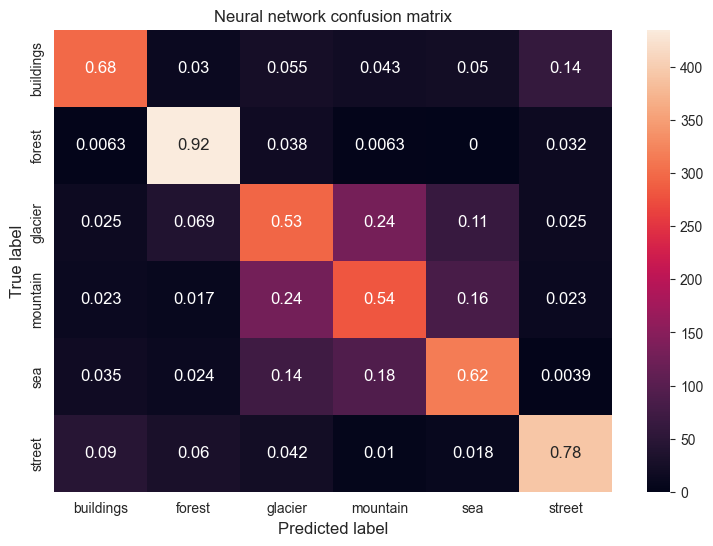

In [24]:
conf = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(9, 6));
sns.heatmap(conf,
            annot=conf / conf.astype(np.float).sum(axis=1, keepdims=True),  #normalized by true class sizes
            annot_kws={"size": 12},
            yticklabels=class2ind.keys(),
            xticklabels=class2ind.keys(),
            )
plt.title('Neural network confusion matrix', fontsize=12);
plt.xlabel('Predicted label', fontsize=12);
plt.ylabel('True label', fontsize=12);

In [25]:
print(classification_report(test_labels, y_pred, target_names=class2ind.keys()))

              precision    recall  f1-score   support

   buildings       0.76      0.68      0.72       437
      forest       0.81      0.92      0.86       474
     glacier       0.53      0.53      0.53       553
    mountain       0.53      0.54      0.53       525
         sea       0.64      0.62      0.63       510
      street       0.79      0.78      0.79       501

    accuracy                           0.67      3000
   macro avg       0.68      0.68      0.68      3000
weighted avg       0.67      0.67      0.67      3000



### Try PSA

In [76]:
pca = PCA(n_components=0.95)

In [78]:
train_df_pca = pca.fit_transform(train_hog_df)
test_df_pca = pca.transform(test_hog_df)

In [79]:
train_df_pca.shape

(11230, 1213)

In [80]:
lr.fit(train_df_pca, train_labels)

LogisticRegression(random_state=42)

In [81]:
y_pred = lr.predict(test_df_pca)
y_probs = lr.predict_proba(test_df_pca)

In [82]:
print(f"Accuracy: {accuracy_score(test_labels, y_pred): .4f}")

Accuracy:  0.6657


After pca accurace got lower. I will leave previous features.

### Huperparameters tunning


In [35]:
lr.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [36]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

params = {'penalty': ['l2', 'l1', 'elasticnet'],
          'C': [0.1, 1, 10, 100]}


grid = GridSearchCV(estimator=lr, param_grid=params, cv=cv, scoring='accuracy', verbose=2)

grid.fit(train_hog_df, train_labels)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ..................................C=0.1, penalty=l2; total time=   8.5s
[CV] END ..................................C=0.1, penalty=l2; total time=   8.2s
[CV] END ..................................C=0.1, penalty=l2; total time=   8.6s
[CV] END ..................................C=0.1, penalty=l2; total time=   7.9s
[CV] END ..................................C=0.1, penalty=l2; total time=   9.0s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.0s
[CV] END ..........................C=0.1, penalty=elasticnet; total time=   0.0s
[CV] END ..........................C=0.1, penalt

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.1, 1, 10, 100],
                         'penalty': ['l2', 'l1', 'elasticnet']},
             scoring='accuracy', verbose=2)

In [37]:
grid.best_params_

{'C': 0.1, 'penalty': 'l2'}

In [26]:
# lr = grid.best_estimator_
lr = LogisticRegression(random_state=42, C=0.1, penalty="l2")
lr.fit(train_hog_df, train_labels)

LogisticRegression(C=0.1, random_state=42)

In [27]:
y_pred = lr.predict(test_hog_df)
y_probs = lr.predict_proba(test_hog_df)

In [28]:
print(f"Accuracy: {accuracy_score(test_labels, y_pred): .4f}")

Accuracy:  0.6870


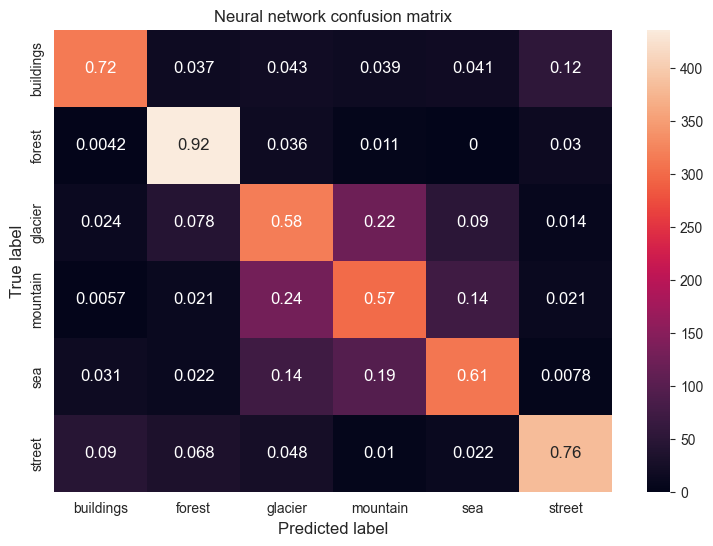

In [29]:
conf = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(9, 6));
sns.heatmap(conf,
            annot=conf / conf.astype(np.float).sum(axis=1, keepdims=True),  #normalized by true class sizes
            annot_kws={"size": 12},
            yticklabels=class2ind.keys(),
            xticklabels=class2ind.keys(),
            )
plt.title('Neural network confusion matrix', fontsize=12);
plt.xlabel('Predicted label', fontsize=12);
plt.ylabel('True label', fontsize=12);

We can see that **forest** class was the easiest to predict for the model. While **glacier** and 8*mountain** was the most difficult: model mixed them for each other.

In [30]:
print(classification_report(test_labels, y_pred, target_names=class2ind.keys()))

              precision    recall  f1-score   support

   buildings       0.80      0.72      0.76       437
      forest       0.79      0.92      0.85       474
     glacier       0.55      0.58      0.56       553
    mountain       0.55      0.57      0.56       525
         sea       0.67      0.61      0.64       510
      street       0.81      0.76      0.79       501

    accuracy                           0.69      3000
   macro avg       0.70      0.69      0.69      3000
weighted avg       0.69      0.69      0.69      3000



### Save accuracy to scores dictionary

In [31]:
scores = {}
scores['LogisticRegression']=accuracy_score(test_labels, y_pred)

In [32]:
auc_scores = calculate_auc_scores(test_labels, y_probs, ind2class.keys())

### Roc-Auc curves

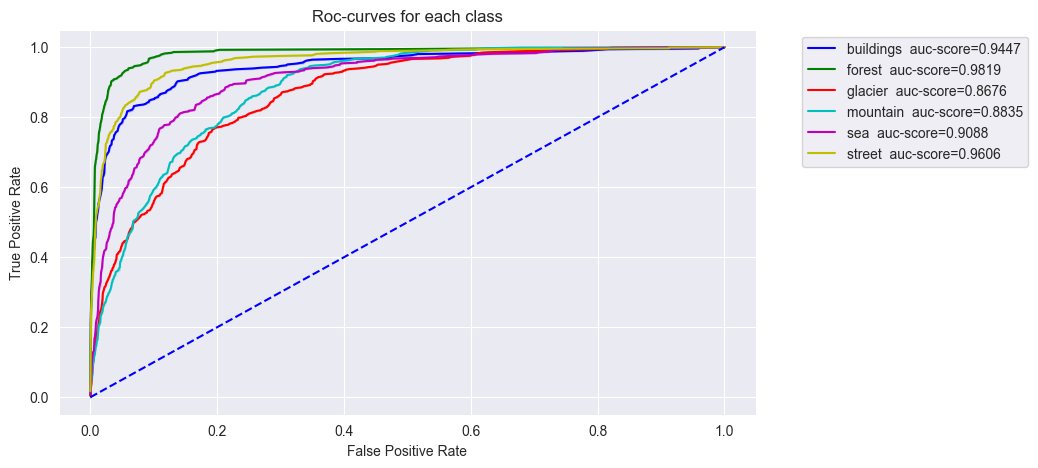

In [33]:
plot_roc_curves_ovr(test_labels,  y_probs, list(class2ind.keys()), auc_scores)

### Precision-recall curves

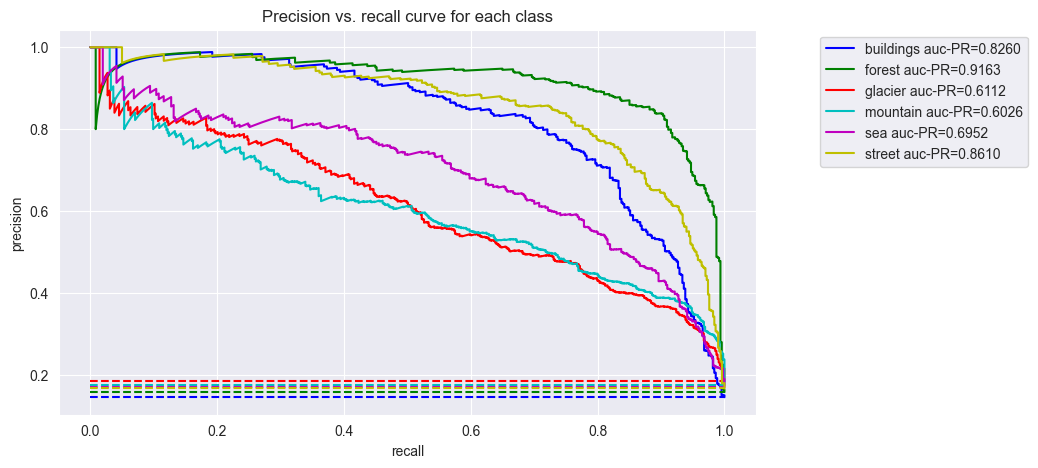

In [34]:
plot_precision_recall_curves(test_labels, y_probs, list(class2ind.keys()))

## KNN

### Base model

In [52]:
knn = KNeighborsClassifier(n_neighbors=5)

In [54]:
knn.fit(train_hog_df, train_labels)

KNeighborsClassifier()

In [55]:
y_pred = knn.predict(test_hog_df)
y_probs = knn.predict_proba(test_hog_df)
print(f"Accuracy: {accuracy_score(test_labels, y_pred): .4f}")

Accuracy:  0.3650


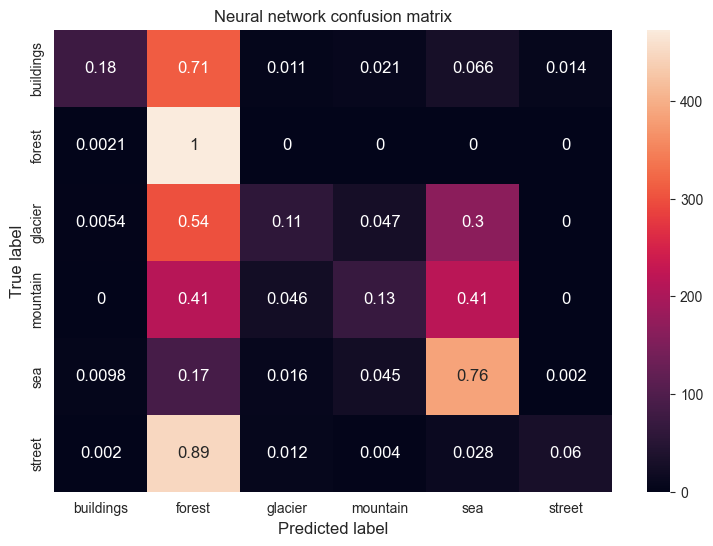

In [56]:
conf = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(9, 6));
sns.heatmap(conf,
            annot=conf / conf.astype(np.float).sum(axis=1, keepdims=True),  #normalized by true class sizes
            annot_kws={"size": 12},
            yticklabels=class2ind.keys(),
            xticklabels=class2ind.keys(),
            )
plt.title('Neural network confusion matrix', fontsize=12);
plt.xlabel('Predicted label', fontsize=12);
plt.ylabel('True label', fontsize=12);

We got very poor predictions. We can see that KNN classifier tends to predict everything as forest.

In [57]:
print(classification_report(test_labels, y_pred, target_names=class2ind.keys()))

              precision    recall  f1-score   support

   buildings       0.89      0.18      0.29       437
      forest       0.26      1.00      0.41       474
     glacier       0.58      0.11      0.18       553
    mountain       0.54      0.13      0.21       525
         sea       0.48      0.76      0.58       510
      street       0.81      0.06      0.11       501

    accuracy                           0.36      3000
   macro avg       0.59      0.37      0.30      3000
weighted avg       0.59      0.36      0.30      3000



### Hyperparameters tunning

In [59]:
knn = KNeighborsClassifier()

In [60]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

params = {
        'n_neighbors': [3, 5, 7, 9, 11, 13],
         'metric': ['euclidian', 'cosine', 'cityblock']
}

grid = GridSearchCV(estimator=knn, param_grid=params, cv=cv, scoring='accuracy', verbose=2)

grid.fit(train_hog_df, train_labels)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ....................metric=euclidian, n_neighbors=3; total time=   0.0s
[CV] END ....................metric=euclidian, n_neighbors=3; total time=   0.0s
[CV] END ....................metric=euclidian, n_neighbors=3; total time=   0.0s
[CV] END ....................metric=euclidian, n_neighbors=3; total time=   0.0s
[CV] END ....................metric=euclidian, n_neighbors=3; total time=   0.0s
[CV] END ....................metric=euclidian, n_neighbors=5; total time=   0.0s
[CV] END ....................metric=euclidian, n_neighbors=5; total time=   0.0s
[CV] END ....................metric=euclidian, n_neighbors=5; total time=   0.0s
[CV] END ....................metric=euclidian, n_neighbors=5; total time=   0.0s
[CV] END ....................metric=euclidian, n_neighbors=5; total time=   0.0s
[CV] END ....................metric=euclidian, n_neighbors=7; total time=   0.0s
[CV] END ....................metric=euclidian, n

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidian', 'cosine', 'cityblock'],
                         'n_neighbors': [3, 5, 7, 9, 11, 13]},
             scoring='accuracy', verbose=2)

In [61]:
grid.best_params_

{'metric': 'cityblock', 'n_neighbors': 3}

In [35]:
# knn = grid.best_estimator_
knn = KNeighborsClassifier(metric='cityblock', n_neighbors=3)
knn.fit(train_hog_df, train_labels)

KNeighborsClassifier(metric='cityblock', n_neighbors=3)

In [36]:
y_pred = knn.predict(test_hog_df)
y_probs = knn.predict_proba(test_hog_df)

In [37]:
print(f"Accuracy: {accuracy_score(test_labels, y_pred): .4f}")

Accuracy:  0.4727


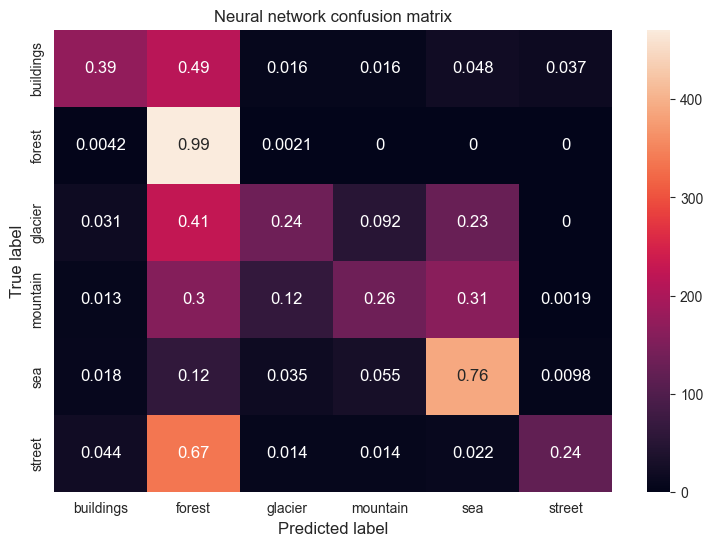

In [38]:
conf = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(9, 6));
sns.heatmap(conf,
            annot=conf / conf.astype(np.float).sum(axis=1, keepdims=True),  #normalized by true class sizes
            annot_kws={"size": 12},
            yticklabels=class2ind.keys(),
            xticklabels=class2ind.keys(),
            )
plt.title('Neural network confusion matrix', fontsize=12);
plt.xlabel('Predicted label', fontsize=12);
plt.ylabel('True label', fontsize=12);

In [39]:
print(classification_report(test_labels, y_pred, target_names=class2ind.keys()))

              precision    recall  f1-score   support

   buildings       0.75      0.39      0.52       437
      forest       0.32      0.99      0.49       474
     glacier       0.58      0.24      0.34       553
    mountain       0.59      0.26      0.36       525
         sea       0.55      0.76      0.64       510
      street       0.84      0.24      0.37       501

    accuracy                           0.47      3000
   macro avg       0.61      0.48      0.45      3000
weighted avg       0.60      0.47      0.45      3000



Here we see that KNN still tends to predict everything as **forest**. Confident true predictions are only **forest** and **see**.

In [40]:
scores['Knn']=accuracy_score(test_labels, y_pred)

### Roc-Auc scores

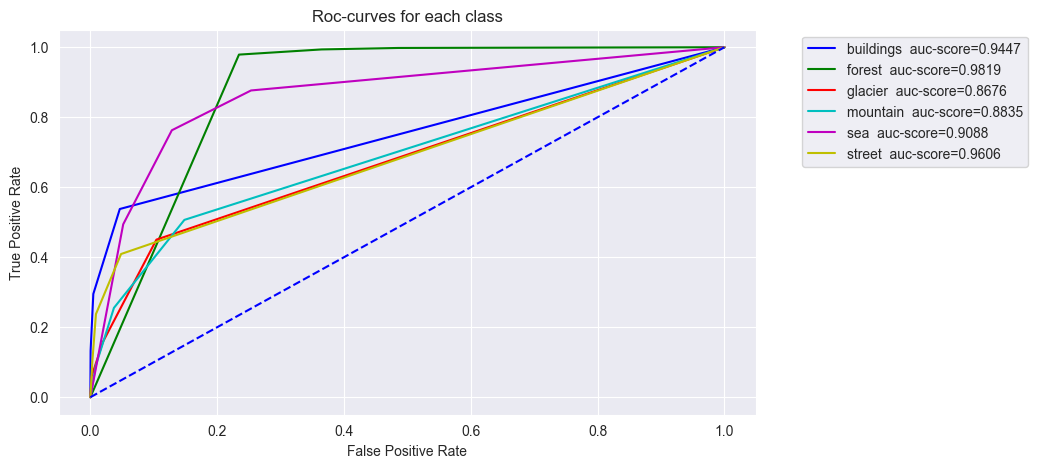

In [41]:
plot_roc_curves_ovr(test_labels, y_probs, list(class2ind.keys()), auc_scores)

### Precision-recall curves

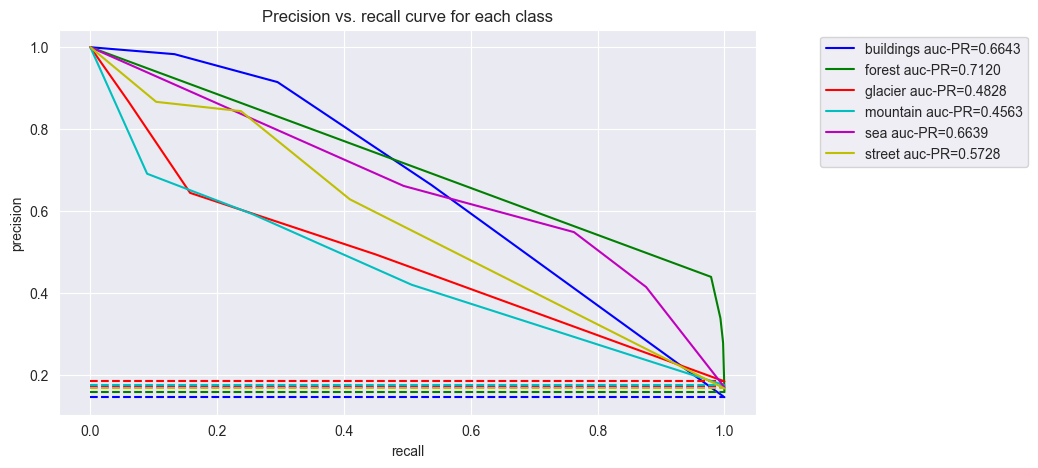

In [42]:
plot_precision_recall_curves(test_labels, y_probs, list(class2ind.keys()))

## SVM

### Base model

In [44]:
svc = SVC(kernel='rbf', random_state=42, probability=True)

In [73]:
svc.fit(train_hog_df, train_labels)

SVC(probability=True, random_state=42)

In [74]:
y_pred = svc.predict(test_hog_df)
y_probs = svc.predict_proba(test_hog_df)
print(f"Accuracy: {accuracy_score(test_labels, y_pred): .4f}")

Accuracy:  0.7410


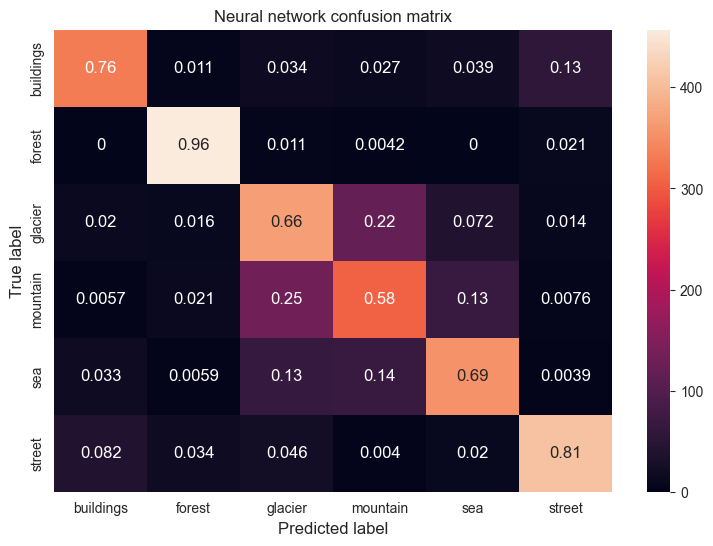

In [75]:
conf = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(9, 6));
sns.heatmap(conf,
            annot=conf / conf.astype(np.float).sum(axis=1, keepdims=True),  #normalized by true class sizes
            annot_kws={"size": 12},
            yticklabels=class2ind.keys(),
            xticklabels=class2ind.keys(),
            )
plt.title('Neural network confusion matrix', fontsize=12);
plt.xlabel('Predicted label', fontsize=12);
plt.ylabel('True label', fontsize=12);

For SVC **forest** and **street** had the best predicted scores, the worst predicted was **mountain**.

In [76]:
print(classification_report(test_labels, y_pred, target_names=class2ind.keys()))

              precision    recall  f1-score   support

   buildings       0.82      0.76      0.79       437
      forest       0.91      0.96      0.94       474
     glacier       0.60      0.66      0.63       553
    mountain       0.60      0.58      0.59       525
         sea       0.72      0.69      0.71       510
      street       0.84      0.81      0.83       501

    accuracy                           0.74      3000
   macro avg       0.75      0.75      0.75      3000
weighted avg       0.74      0.74      0.74      3000



### Hyperparameters tunning

It was too slow, that's why I used only a few values of parameters.

In [46]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

params = {
        'C': [1, 100],
         'gamma': [0.01, 10]
}

grid = GridSearchCV(estimator=svc, param_grid=params, cv=cv, scoring='accuracy', verbose=2)

grid.fit(train_hog_df, train_labels)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ....................................C=1, gamma=0.01; total time= 6.6min
[CV] END ....................................C=1, gamma=0.01; total time= 6.4min
[CV] END ....................................C=1, gamma=0.01; total time= 6.6min
[CV] END ......................................C=1, gamma=10; total time=15.8min
[CV] END ......................................C=1, gamma=10; total time=15.0min
[CV] END ......................................C=1, gamma=10; total time=15.1min
[CV] END ..................................C=100, gamma=0.01; total time= 7.0min
[CV] END ..................................C=100, gamma=0.01; total time= 6.9min
[CV] END ..................................C=100, gamma=0.01; total time= 6.9min
[CV] END ....................................C=100, gamma=10; total time=15.0min
[CV] END ....................................C=100, gamma=10; total time=15.2min
[CV] END ....................................C=10

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=SVC(probability=True, random_state=42),
             param_grid={'C': [1, 100], 'gamma': [0.01, 10]},
             scoring='accuracy', verbose=2)

In [47]:
grid.best_params_

{'C': 100, 'gamma': 0.01}

In [49]:
svc = grid.best_estimator_
svc.fit(train_hog_df, train_labels)

SVC(C=100, gamma=0.01, probability=True, random_state=42)

In [50]:
y_pred = svc.predict(test_hog_df)
y_probs = svc.predict_proba(test_hog_df)
print(f"Accuracy: {accuracy_score(test_labels, y_pred): .4f}")

Accuracy:  0.7303


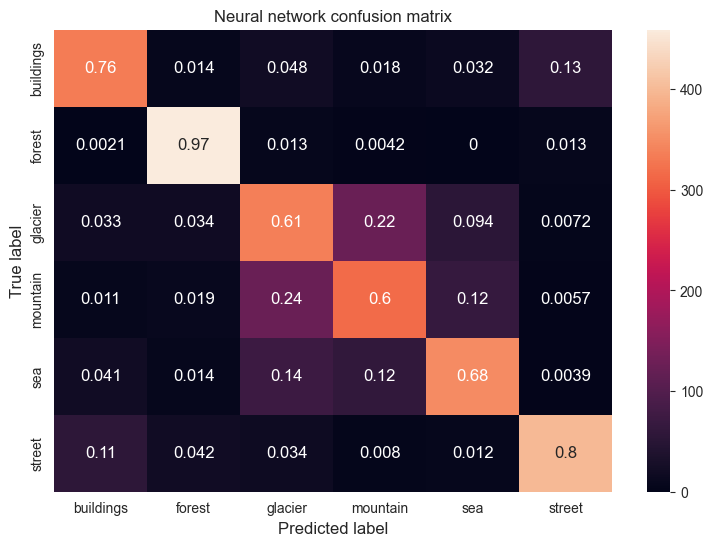

In [51]:
conf = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(9, 6));
sns.heatmap(conf,
            annot=conf / conf.astype(np.float).sum(axis=1, keepdims=True),  #normalized by true class sizes
            annot_kws={"size": 12},
            yticklabels=class2ind.keys(),
            xticklabels=class2ind.keys(),
            )
plt.title('Neural network confusion matrix', fontsize=12);
plt.xlabel('Predicted label', fontsize=12);
plt.ylabel('True label', fontsize=12);

In [52]:
print(classification_report(test_labels, y_pred, target_names=class2ind.keys()))

              precision    recall  f1-score   support

   buildings       0.77      0.76      0.76       437
      forest       0.88      0.97      0.92       474
     glacier       0.58      0.61      0.60       553
    mountain       0.62      0.60      0.61       525
         sea       0.72      0.68      0.70       510
      street       0.85      0.80      0.82       501

    accuracy                           0.73      3000
   macro avg       0.74      0.74      0.74      3000
weighted avg       0.73      0.73      0.73      3000



In [53]:
scores['SVC']=accuracy_score(test_labels, y_pred)

### Roc-Auc scores

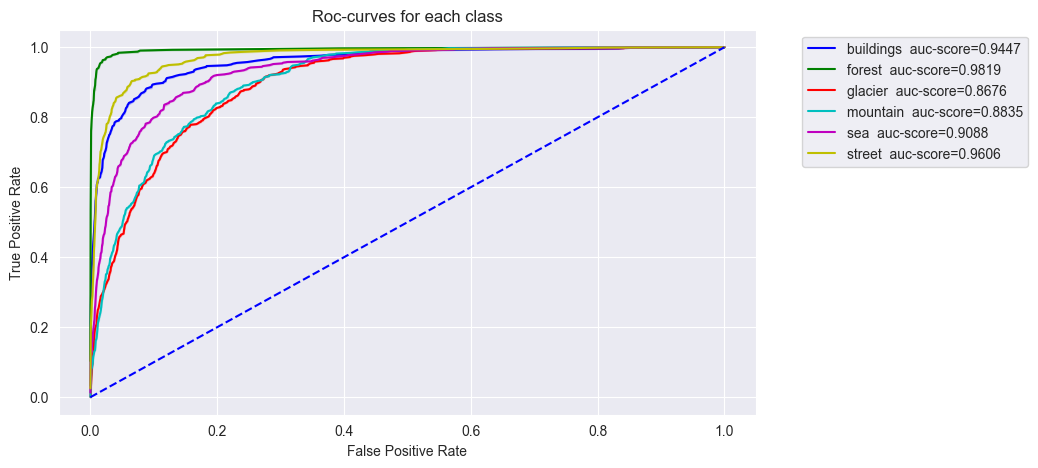

In [54]:
plot_roc_curves_ovr(test_labels, y_probs, list(class2ind.keys()), auc_scores)

### Precision-recall curves

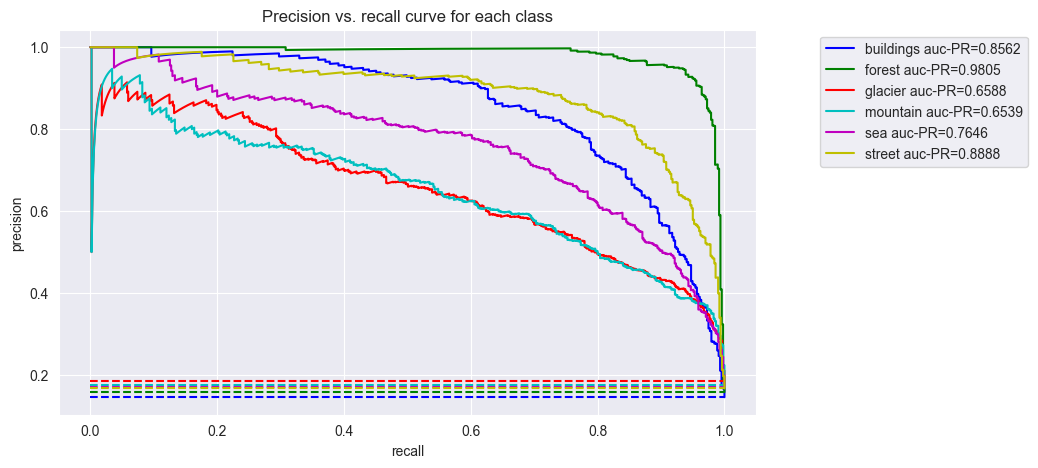

In [55]:
plot_precision_recall_curves(test_labels, y_probs, list(class2ind.keys()))

In [56]:
scores

{'LogisticRegression': 0.687,
 'Knn': 0.4726666666666667,
 'SVC': 0.7303333333333333}

## Compare classical ML classifiers

In [107]:
scores_df = pd.DataFrame.from_dict(scores, orient='index', columns=['accuracy'])
scores_df=scores_df.reset_index()
scores_df.columns = ["classifier", "accuracy"]

In [108]:
scores_df

classifier  accuracy
0  LogisticRegression  0.687000
1                 Knn  0.472667
2                 SVC  0.730333

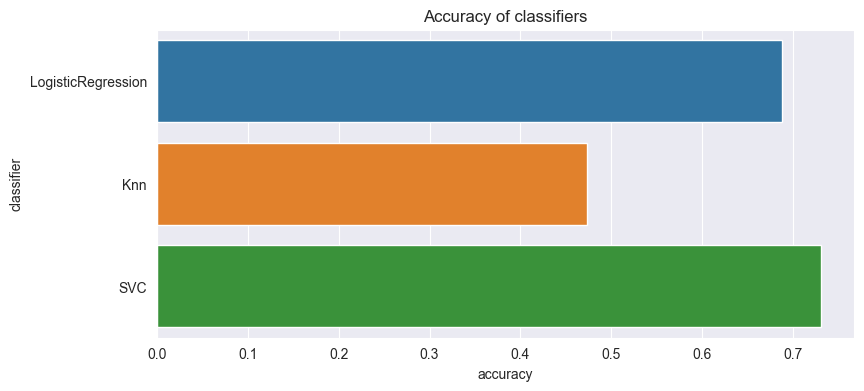

In [99]:
plt.figure(figsize=(9,4))
sns.barplot(scores_df, y="classifier", x='accuracy')
plt.title("Accuracy of classifiers")
plt.show()

We can see that among classical ML classifiers the best accuracy was achieved with SVC classifier and the worst with KNN.

# NN approach

### Create dataset of image folders

In [3]:
#make seed for the same randomness
torch.manual_seed(42)

In [4]:
train_path = "Classification_data/train/"
test_path = "Classification_data/test/"
val_path = "Classification_data/validation/"

In [23]:
train_transform = transforms.Compose([
    transforms.Resize(size=(150, 150)),
    transforms.RandomRotation((0,40)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop((150, 150), scale=(0.2, 1), ratio=(1, 1)),
    transforms.ToTensor(), #rescale image from (0-255) to (0,1)
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #normalization from ImageNet
])


val_transform = transforms.Compose([
    transforms.Resize(size=(150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


test_transform = transforms.Compose([
    transforms.Resize(size=(150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])



In [24]:
train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
val_dataset = datasets.ImageFolder(val_path, transform=val_transform)
test_dataset = datasets.ImageFolder(test_path, transform=test_transform)

In [25]:
BATCH_SIZE = 64

In [26]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [27]:
train_dataset.classes

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [22]:
class CNN(torch.nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.convolutional_layers = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), #output 16x150x150
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(num_features=16),
            torch.nn.MaxPool2d(kernel_size=(2,2)),#output 16x75x75

            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(num_features=32),
            torch.nn.MaxPool2d(kernel_size=(2,2)), #output 32x37x37

            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.MaxPool2d(kernel_size=(2,2)), #output 64x18x18

            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(num_features=128),
            torch.nn.MaxPool2d(kernel_size=(2,2)), #output 128x9x9


        )

        #fully connected layer
        self.dense_layers = torch.nn.Sequential(
            nn.Flatten(),
            torch.nn.Linear(9*9*128, 512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(512, num_classes)
        )
    # fo
    def forward(self, X):
        out = self.convolutional_layers(X)
        out = self.dense_layers(out)
        return out

In [28]:
model = CNN(num_classes=6)

In [14]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimization of learning rate by factor 0.9 if there is no improvement for 5 epochs
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.9, patience=5, verbose=True)

In [15]:
def train_CNN(model, loss, optimizer, train_loader, val_loader, epochs):
  train_losses = np.zeros(epochs)
  val_losses = np.zeros(epochs)
  train_accs=np.zeros(epochs)
  val_accs=np.zeros(epochs)



  for epoch in range(epochs):
    model.train()
    t0 = datetime.datetime.now()


    train_loss=[]
    train_correct, train_total = 0.0, 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()

        losses = loss(outputs, targets)
        losses.backward()
        optimizer.step()
        train_loss.append(losses.item())
        train_correct+=(outputs.argmax(axis=1)==targets).sum()
        train_total+=targets.shape[0]


    train_loss = np.mean(train_loss)




    model.eval()
    val_loss=[]
    val_correct, val_total = 0.0, 0.0
    for inputs, targets in val_loader:
        outputs = model(inputs).squeeze()
        losses = loss(outputs, targets)
        val_loss.append(losses.item())
        val_correct+=(outputs.argmax(axis=1)==targets).sum()
        val_total+=targets.shape[0]


    val_loss = np.mean(val_loss)
    #check the learning rate
    scheduler.step(val_loss)

    train_losses[epoch] = train_loss
    val_losses[epoch] = val_loss
    train_accs[epoch]= train_correct/train_total #overall accuracy per epoch
    val_accs[epoch]=val_correct/val_total

    dt = datetime.datetime.now() - t0
    print(f'Epoch {epoch+1}/{epochs}  Train Loss: {train_loss:.4f}  Train Acc: {train_correct/train_total: .4f} Val Loss: {val_loss:.4f} Val Acc: {val_correct/val_total: .4f} Duration: {dt}')

  return train_losses, val_losses, train_accs, val_accs

In [16]:
EPOCHS = 100
train_losses, val_losses, train_accs, val_accs = train_CNN(model, loss, optimizer, train_dataloader, val_dataloader,
                                                           EPOCHS)

KeyError: 'You have to pass data to augmentations as named arguments, for example: aug(image=image)'

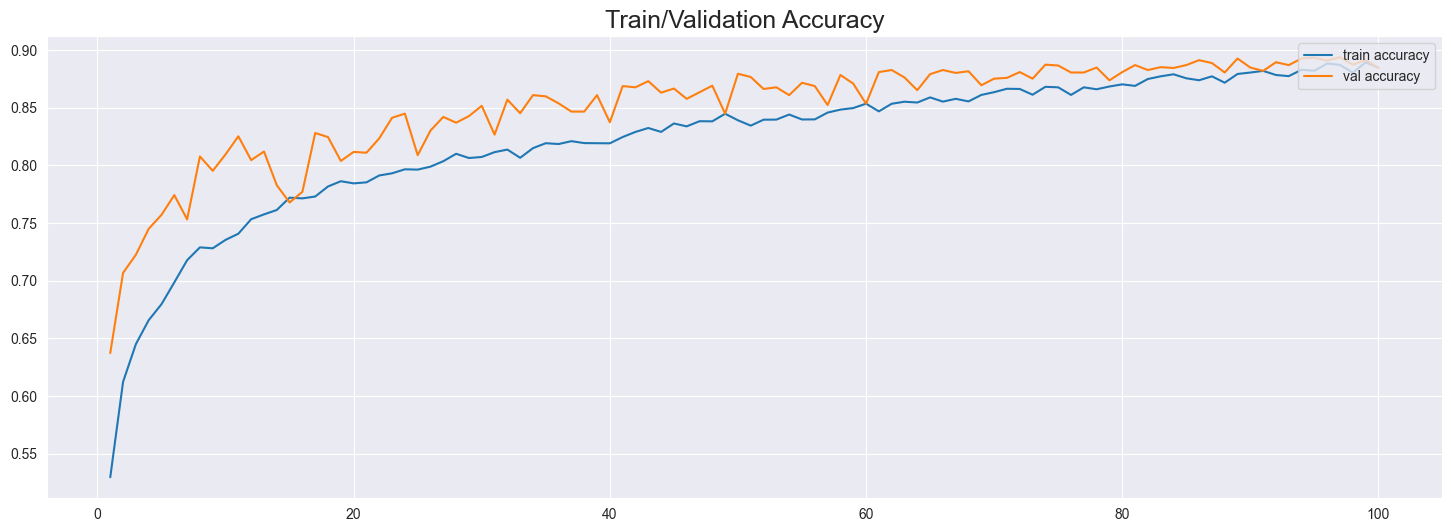

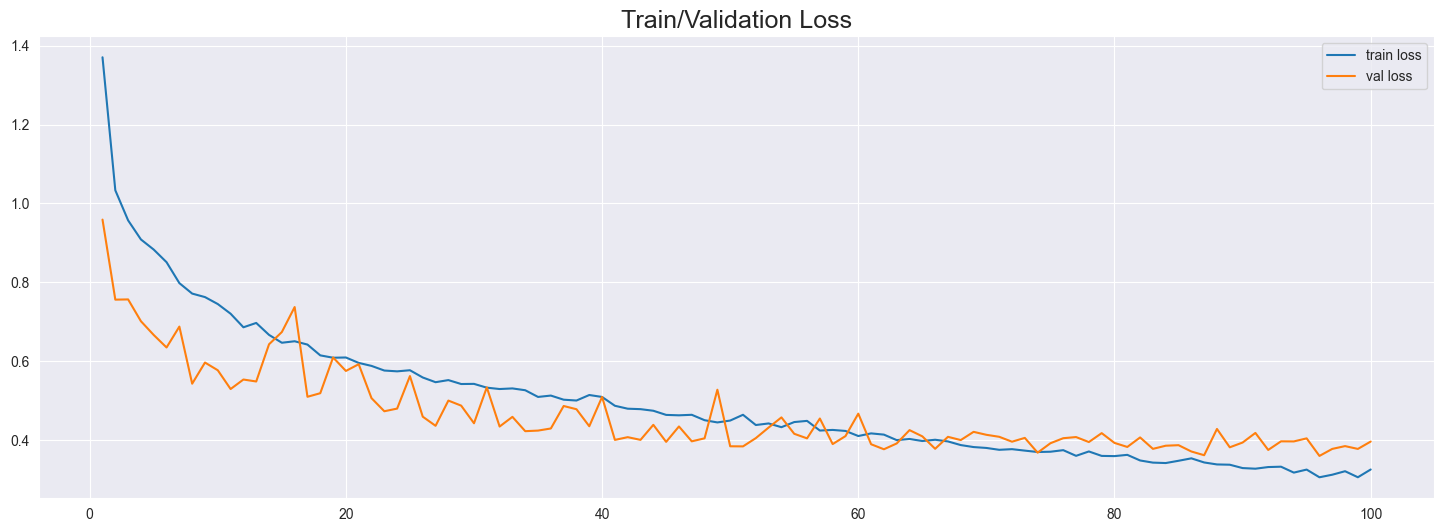

In [179]:
plt.figure(figsize=(18,6))
plt.plot(range(1,EPOCHS+1), train_accs, label='train accuracy')
plt.plot(range(1,EPOCHS+1), val_accs, label="val accuracy")
plt.legend(loc='upper right')
plt.title("Train/Validation Accuracy", fontsize=18)
plt.show()

plt.figure(figsize=(18,6))
plt.plot(range(1,EPOCHS+1), train_losses, label='train loss')
plt.plot(range(1,EPOCHS+1), val_losses, label="val loss")
plt.legend(loc='upper right')
plt.title("Train/Validation Loss", fontsize=18)
plt.show()

Save model

In [180]:
torch.save(model.state_dict(), "models/basic_CNN.pt")

Load model

In [29]:
model = CNN(num_classes=6)
model.load_state_dict(torch.load("models/basic_CNN.pt"))

<All keys matched successfully>

### Model evaluation

In [20]:
def evaluate(model, test_loader):
    '''
    computes predictions and probabilities of each prediction by batch
    :return: predictions, probs and targets
    '''
    predictions =[]
    probs = []
    targets = []
    softmax = nn.Softmax(dim=1)
    model.eval()

    for inputs, labels in test_loader:
        outputs = model(inputs)
        #compute probabilities
        y_probs = softmax(outputs)
        y_probs = y_probs.detach().numpy()
        #compute classes
        y_pred = y_probs.argmax(axis=1)

        predictions.extend(y_pred)
        probs.extend(y_probs)
        targets.extend(labels.numpy())


    return predictions, np.array(probs), targets



In [30]:
y_pred, y_probs, labels = evaluate(model, test_dataloader)

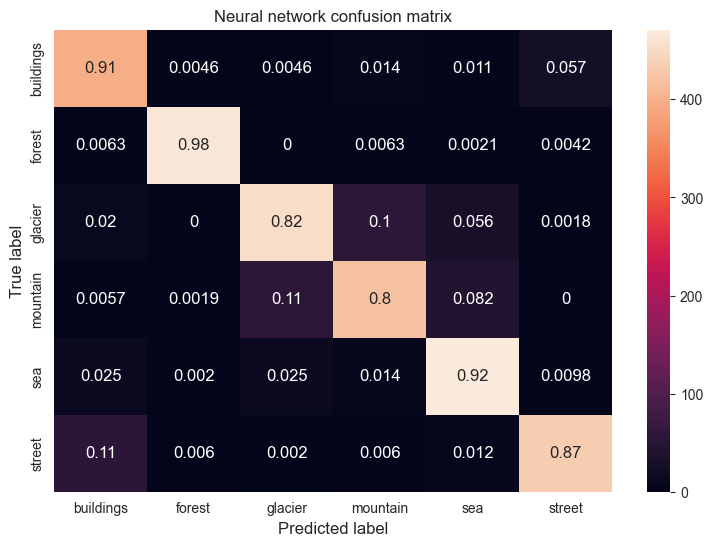

In [31]:
conf = confusion_matrix(labels, y_pred)
plt.figure(figsize=(9, 6));
sns.heatmap(conf,
            annot=conf / conf.astype(np.float).sum(axis=1, keepdims=True),  #normalized by true class sizes
            annot_kws={"size": 12},
            yticklabels=train_dataset.classes,
            xticklabels=train_dataset.classes,
            )
plt.title('Neural network confusion matrix', fontsize=12);
plt.xlabel('Predicted label', fontsize=12);
plt.ylabel('True label', fontsize=12);

In [32]:
print(classification_report(labels, y_pred, target_names=train_dataset.classes))

              precision    recall  f1-score   support

   buildings       0.83      0.91      0.86       437
      forest       0.99      0.98      0.98       474
     glacier       0.86      0.82      0.84       553
    mountain       0.85      0.80      0.82       525
         sea       0.85      0.92      0.88       510
      street       0.93      0.87      0.90       501

    accuracy                           0.88      3000
   macro avg       0.88      0.88      0.88      3000
weighted avg       0.88      0.88      0.88      3000



### Roc-AUC curves

In [88]:
auc_scores = calculate_auc_scores(labels, y_probs, train_dataset.classes)

### Roc-curves for each class

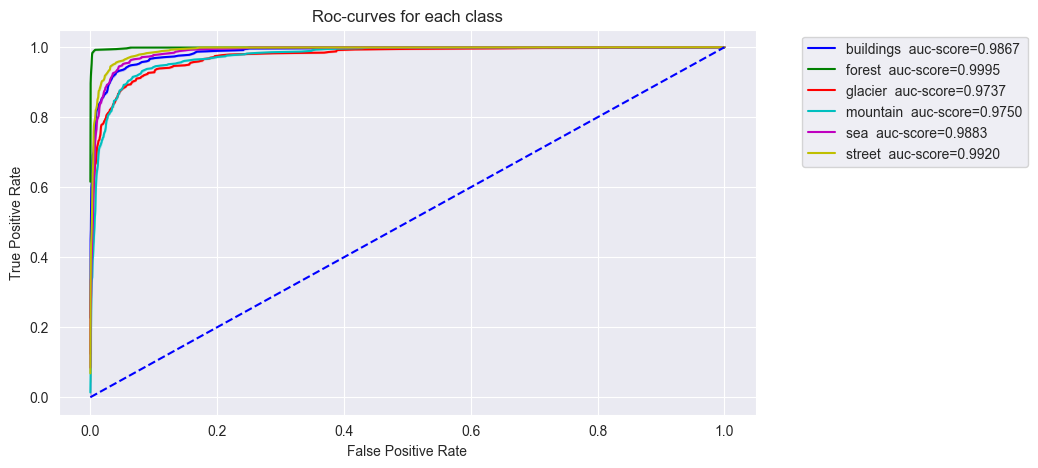

In [89]:
plot_roc_curves_ovr(labels, y_probs, train_dataset.classes, auc_scores)

### Precision-recall curves for each class

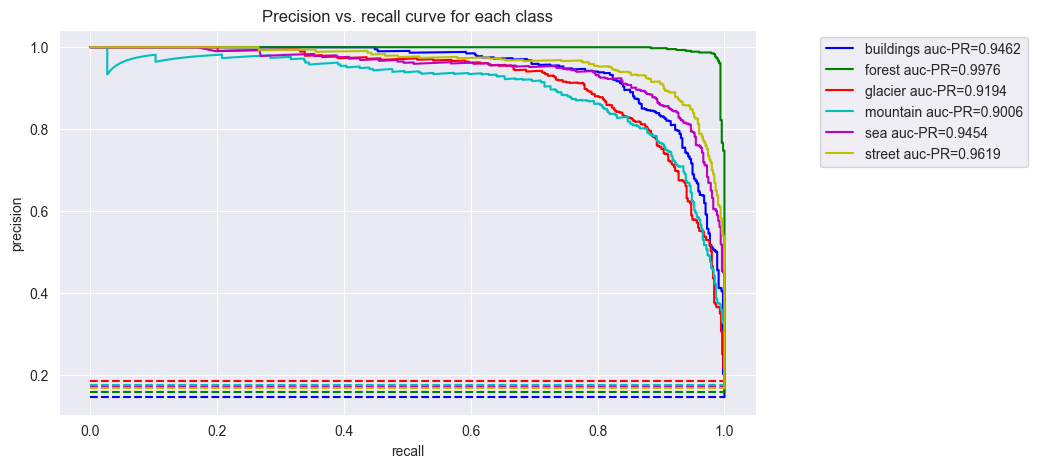

In [90]:
plot_precision_recall_curves(labels, y_probs, train_dataset.classes)

Add accuracy to the scores

In [112]:
scores_df =scores_df.append( {"classifier": "Base NN", "accuracy": accuracy_score(y_pred, labels)}, ignore_index=True)

In [115]:
scores_df

classifier  accuracy
0  LogisticRegression  0.687000
1                 Knn  0.472667
2                 SVC  0.730333
4             Base NN  0.880333

### Visualization of predictions

Show 20 random predictions from test set

In [33]:
X_test, labels = next(iter(test_dataloader))

outputs = model(X_test)
#compute probabilities
softmax = nn.Softmax(dim=1)
y_probs = softmax(outputs)
y_probs = y_probs.detach().numpy()
#compute classes
y_pred = y_probs.argmax(axis=1)

In [34]:
def show_predictions(X_test, labels, y_pred):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    plt.figure(figsize=(20, 10))
    #choose random 20 pictures
    idx = np.random.randint(0, len(X_test), 20)
    for i, index in enumerate(idx):
        ax = plt.subplot(4, 5, i + 1)
        img=X_test[index].numpy().transpose((1,2,0));
        #inverse transformation from standartization
        img=img*std+mean;
        plt.imshow(img)
        true_label = train_dataset.classes[labels[index]]
        predicted_label = train_dataset.classes[y_pred[index]]
        color = "green" if true_label == predicted_label else "red"
        plt.title(f"Label: {true_label} \n Predicted: {predicted_label}", color=color)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

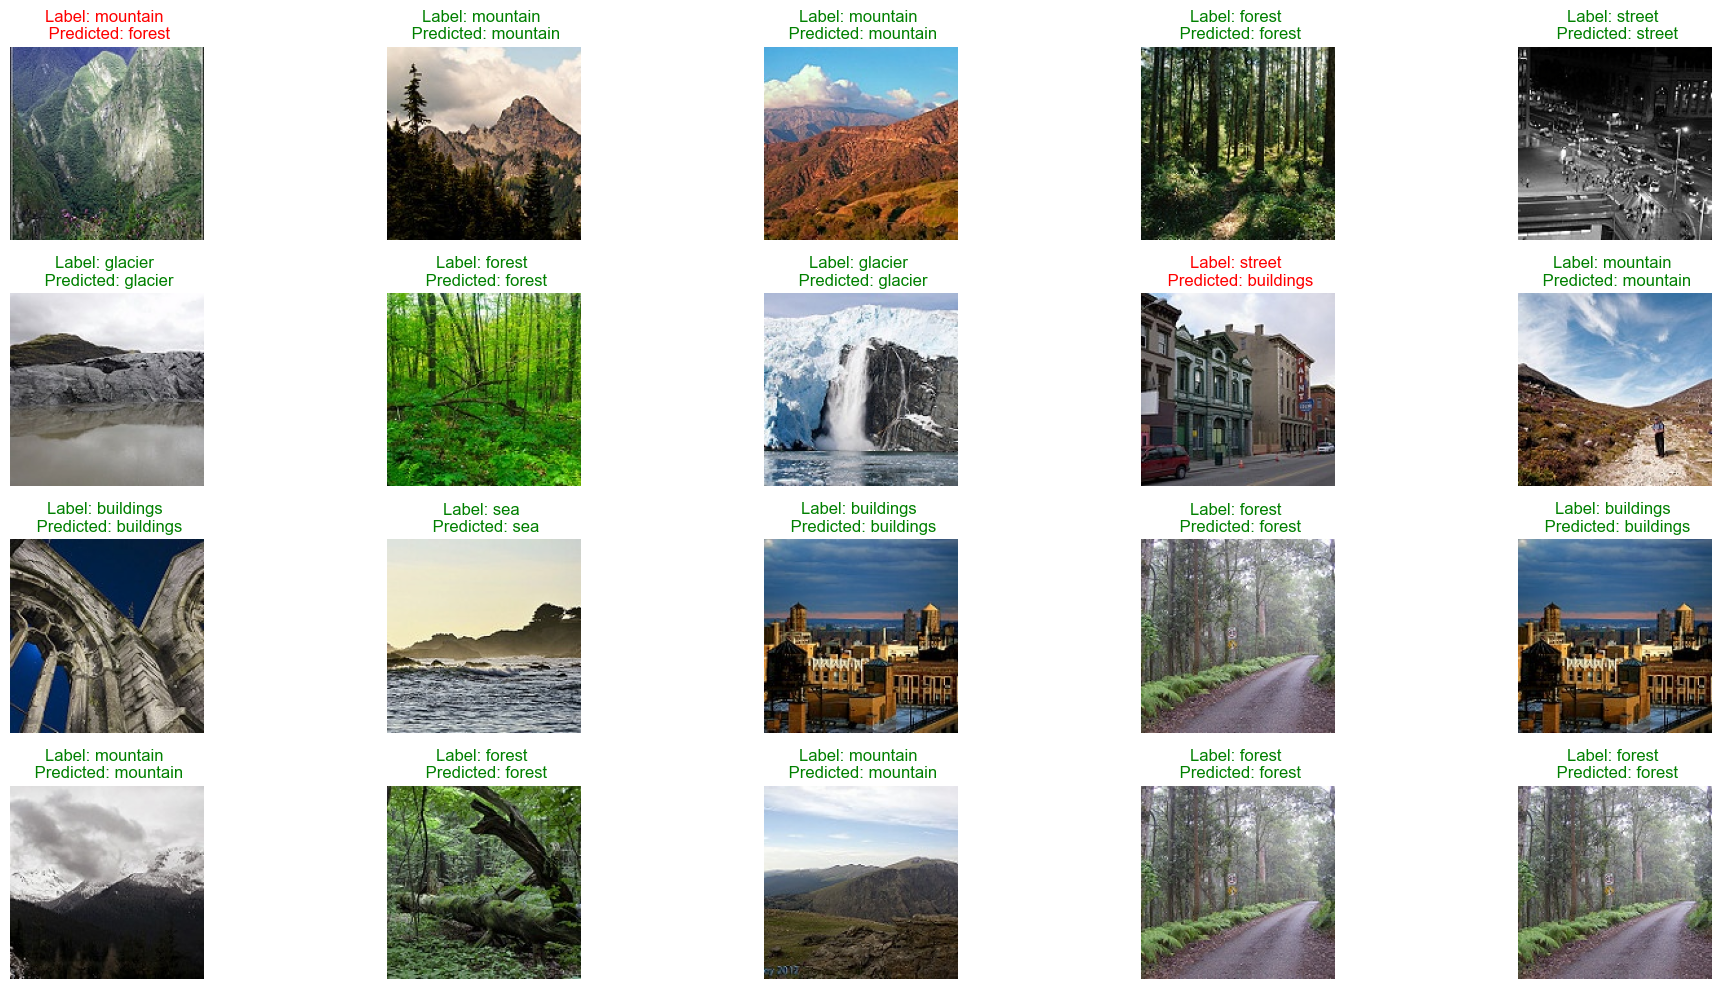

In [35]:
show_predictions(X_test, labels, y_pred)

# Fine-tuned CNN

I will use pretrained model VGG19.

In [116]:
vgg19_model = models.vgg19(pretrained=True)

In [117]:
# freeze parameters in all layers
for param in vgg19_model.parameters():
    param.requires_grad = False

In [118]:
vgg19_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [119]:
# change output features of the last classification layer to 6 classes
vgg19_model.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096, bias=True),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=4096, out_features=6, bias=True)
)

To use VGG19 I will change transformation of images: resize images from 150X150 to 224X224, as it is needed for the architecture of VGG19.

In [120]:
#transformation with augmentation
train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.RandomRotation((0,40)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop((224, 224), scale=(0.2, 1), ratio=(1, 1)),
    transforms.ToTensor(), #rescale image from (0-255) to (0,1)
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #normalization from ImageNet
])

val_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [121]:
train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
test_dataset = datasets.ImageFolder(test_path, transform=test_transform)
val_dataset = datasets.ImageFolder(val_path, transform=val_transform)

In [122]:
BATCH_SIZE = 64

In [123]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [124]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg19_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, patience=5, verbose=True)

In [125]:
EPOCHS = 5
train_losses, val_losses, train_accs, val_accs = train_CNN(vgg19_model, loss, optimizer, train_dataloader, val_dataloader, EPOCHS)

Epoch 1/5  Train Loss: 0.7937  Train Acc:  0.7774 Val Loss: 0.2814 Val Acc:  0.9044 Duration: 0:35:16.572951
Epoch 2/5  Train Loss: 0.4769  Train Acc:  0.8348 Val Loss: 0.2989 Val Acc:  0.9069 Duration: 0:36:00.340439
Epoch 3/5  Train Loss: 0.4790  Train Acc:  0.8326 Val Loss: 0.3142 Val Acc:  0.8984 Duration: 0:35:52.947368
Epoch 4/5  Train Loss: 0.4786  Train Acc:  0.8427 Val Loss: 0.2601 Val Acc:  0.9123 Duration: 0:36:56.080335
Epoch 5/5  Train Loss: 0.4813  Train Acc:  0.8394 Val Loss: 0.2732 Val Acc:  0.9162 Duration: 0:35:35.720330


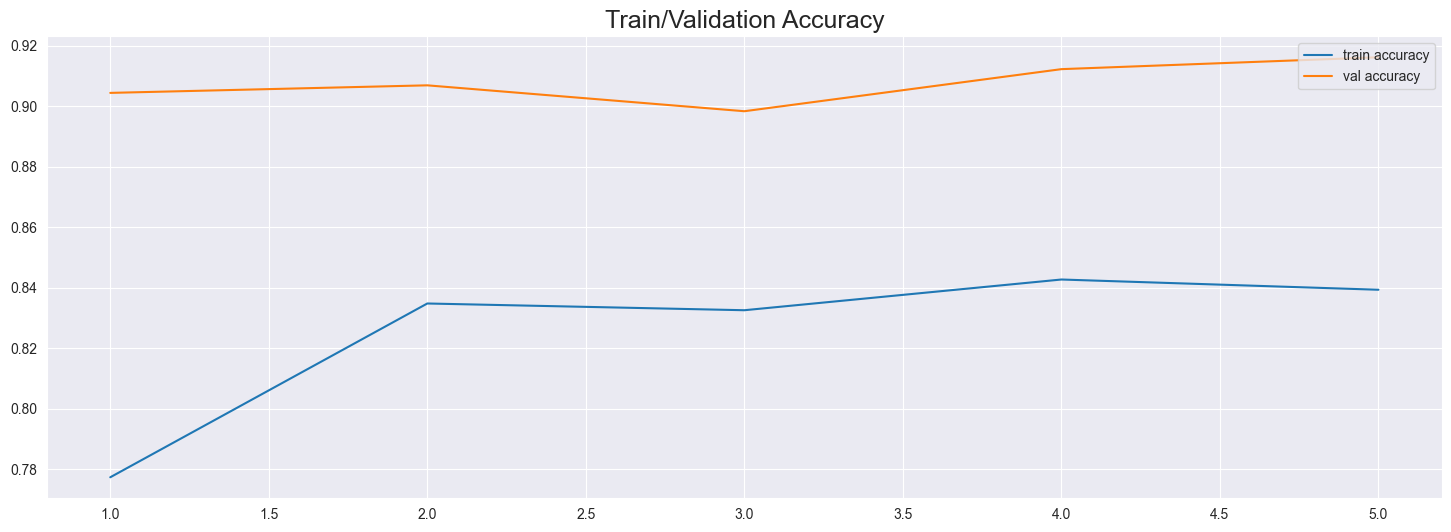

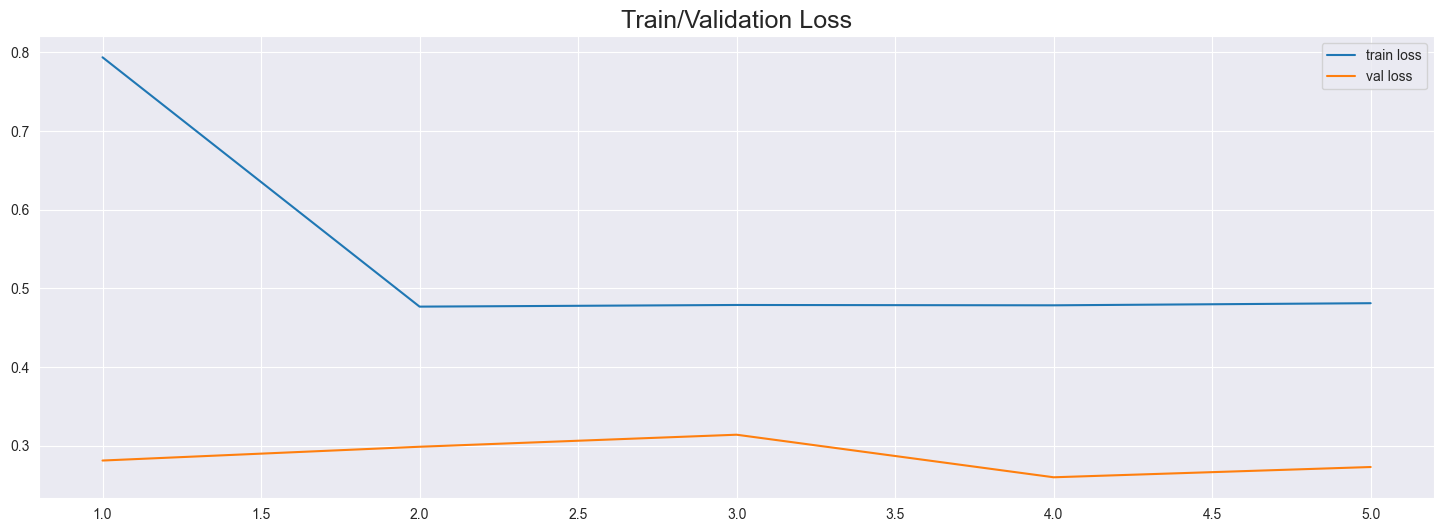

In [126]:
plt.figure(figsize=(18,6))
plt.plot(range(1,EPOCHS+1), train_accs, label='train accuracy')
plt.plot(range(1,EPOCHS+1), val_accs, label="val accuracy")
plt.legend(loc='upper right')
plt.title("Train/Validation Accuracy", fontsize=18)
plt.show()

plt.figure(figsize=(18,6))
plt.plot(range(1,EPOCHS+1), train_losses, label='train loss')
plt.plot(range(1,EPOCHS+1), val_losses, label="val loss")
plt.legend(loc='upper right')
plt.title("Train/Validation Loss", fontsize=18)
plt.show()

Save model

In [127]:
torch.save(vgg19_model.state_dict(), "models/vgg19_model.pt")

Load model

In [128]:
vgg19_model.load_state_dict(torch.load("models/vgg19_model.pt"))
vgg19_model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

### Evaluate model on the test set

In [130]:
y_pred, y_probs, labels = evaluate(vgg19_model, test_dataloader)

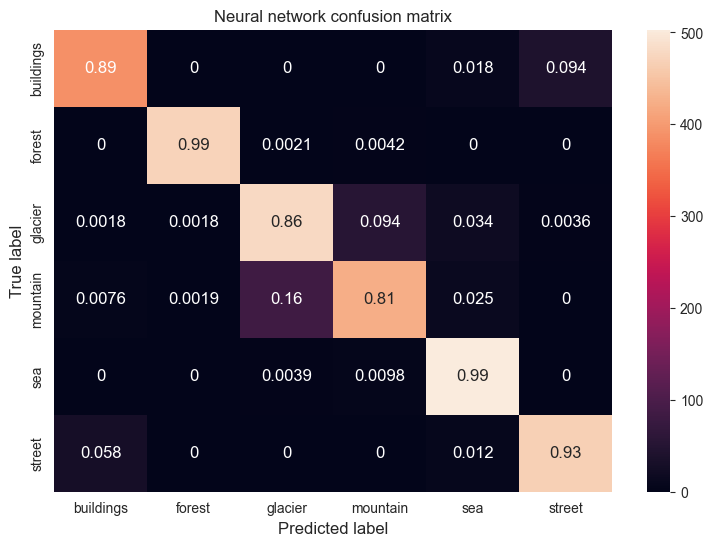

In [131]:
conf = confusion_matrix(labels, y_pred)
plt.figure(figsize=(9, 6));
sns.heatmap(conf,
            annot=conf / conf.astype(np.float).sum(axis=1, keepdims=True),  #normalized by true class sizes
            annot_kws={"size": 12},
            yticklabels=train_dataset.classes,
            xticklabels=train_dataset.classes,
            )
plt.title('Neural network confusion matrix', fontsize=12);
plt.xlabel('Predicted label', fontsize=12);
plt.ylabel('True label', fontsize=12);

In [132]:
print(classification_report(labels, y_pred, target_names=train_dataset.classes))

              precision    recall  f1-score   support

   buildings       0.92      0.89      0.90       437
      forest       1.00      0.99      0.99       474
     glacier       0.85      0.86      0.86       553
    mountain       0.88      0.81      0.84       525
         sea       0.92      0.99      0.95       510
      street       0.92      0.93      0.92       501

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000



### Roc-curves for each class

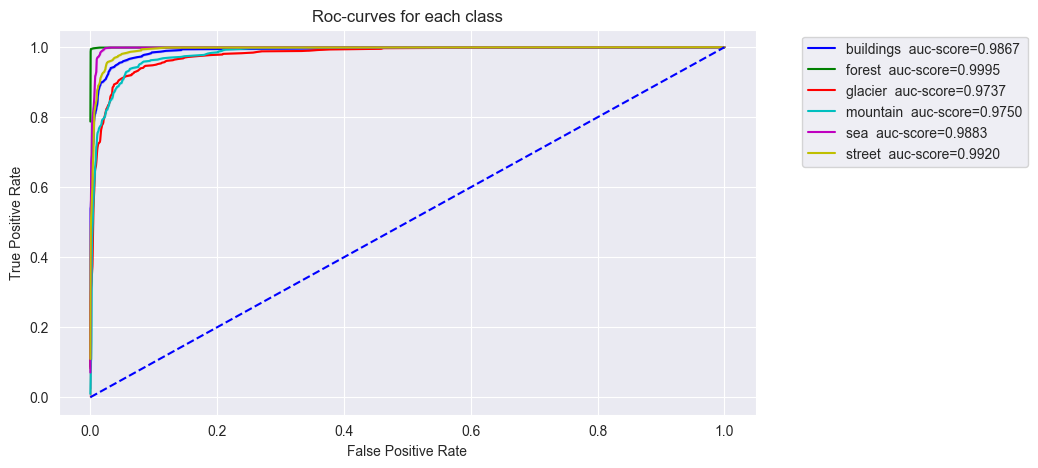

In [134]:
plot_roc_curves_ovr(labels, y_probs, train_dataset.classes, auc_scores)

### Precision-recall curves for each class

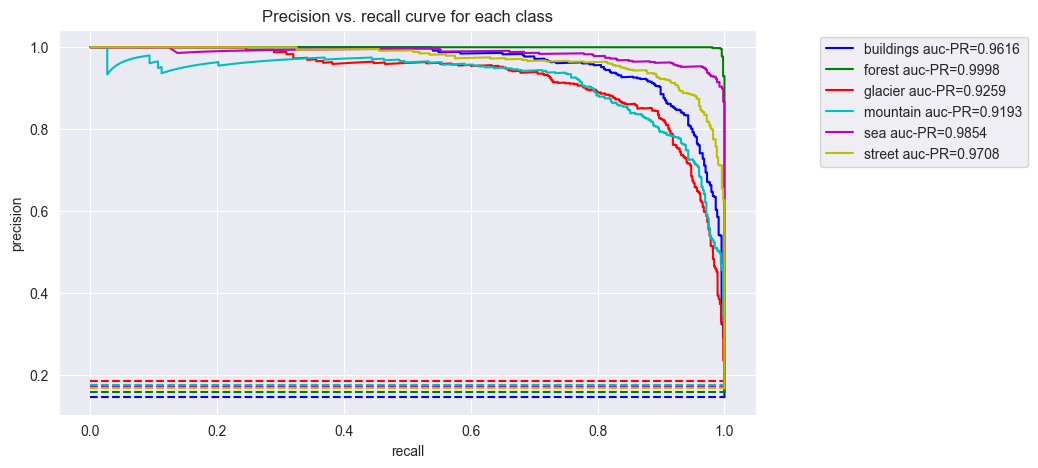

In [135]:
plot_precision_recall_curves(labels, y_probs, train_dataset.classes)

### Visualization of predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

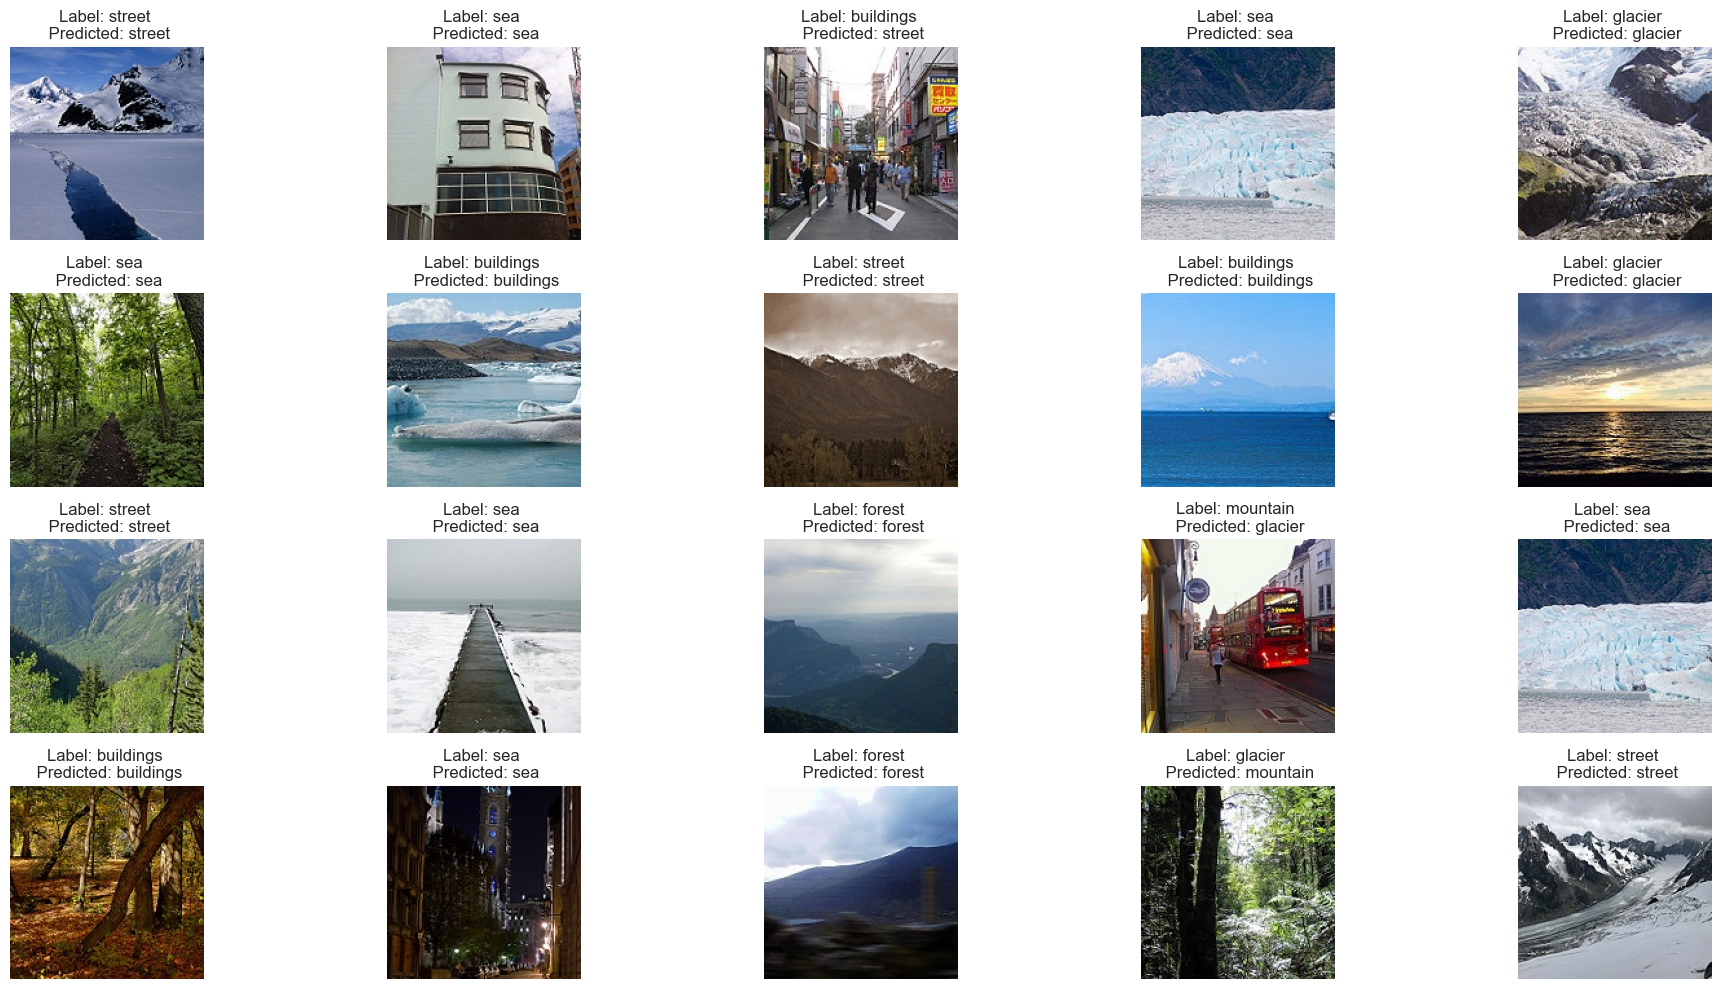

In [136]:
show_predictions(X_test, labels, y_pred)

In [137]:
scores_df = scores_df.append({"classifier": "Ptretrained VGG19", "accuracy": accuracy_score(y_pred, labels)}, ignore_index=True)
scores_df

classifier  accuracy
0  LogisticRegression  0.687000
1                 Knn  0.472667
2                 SVC  0.730333
3             Base NN  0.880333
4   Ptretrained VGG19  0.910000

### Compare classifiers

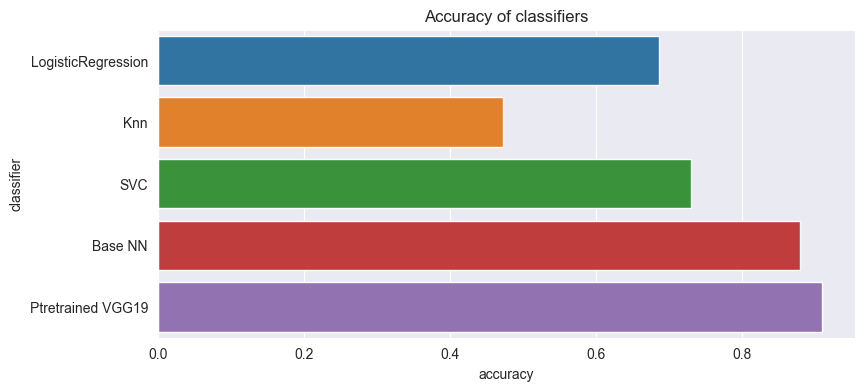

In [138]:
plt.figure(figsize=(9,4))
sns.barplot(scores_df, y="classifier", x='accuracy')
plt.title("Accuracy of classifiers")
plt.show()